# Import Libraries

In [1]:
import os
import time
import scipy.io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

%config InlineBackend.figure_format = "retina"

# Datasets

In [2]:
# Motion Datasets
m_left_datas_1, m_left_datas_2, m_left_datas_3 = scipy.io.loadmat('dataset/mat/left_1_2-4.mat'), scipy.io.loadmat('dataset/mat/left_2_2-4.mat'), scipy.io.loadmat('dataset/mat/left_3_2-4.mat')
m_right_datas_1, m_right_datas_2, m_right_datas_3 = scipy.io.loadmat('dataset/mat/right_1_2-4.mat'), scipy.io.loadmat('dataset/mat/right_2_2-4.mat'), scipy.io.loadmat('dataset/mat/right_3_2-4.mat')

# Duration Datasets
d_left_datas_1, d_left_datas_2, d_left_datas_3 = scipy.io.loadmat('dataset/mat/left_1_1.5-3.mat'), scipy.io.loadmat('dataset/mat/left_2_1.5-3.mat'), scipy.io.loadmat('dataset/mat/left_3_1.5-3.mat')
d_right_datas_1, d_right_datas_2, d_right_datas_3 = scipy.io.loadmat('dataset/mat/right_1_1.5-3.mat'), scipy.io.loadmat('dataset/mat/right_2_1.5-3.mat'), scipy.io.loadmat('dataset/mat/right_3_1.5-3.mat')

# Preparation Datasets
p_left_datas_1, p_left_datas_2, p_left_datas_3 = scipy.io.loadmat('dataset/mat/left_1_1-2.mat'), scipy.io.loadmat('dataset/mat/left_2_1-2.mat'), scipy.io.loadmat('dataset/mat/left_3_1-2.mat')
p_right_datas_1, p_right_datas_2, p_right_datas_3 = scipy.io.loadmat('dataset/mat/right_1_1-2.mat'), scipy.io.loadmat('dataset/mat/right_2_1-2.mat'), scipy.io.loadmat('dataset/mat/right_3_1-2.mat')

In [3]:
# Motion with all channels
m_all_left_datas = np.delete(np.concatenate((m_left_datas_1['left'], m_left_datas_2['left'], m_left_datas_3['left']), axis = 2), 31, 0)
m_all_right_datas = np.delete(np.concatenate((m_right_datas_1['right'], m_right_datas_2['right'], m_right_datas_3['right']), axis = 2), 31, 0)

# Duration with all channels
d_all_left_datas = np.delete(np.concatenate((d_left_datas_1['left'], d_left_datas_2['left'], d_left_datas_3['left']), axis = 2), 31, 0)
d_all_right_datas = np.delete(np.concatenate((d_right_datas_1['right'], d_right_datas_2['right'], d_right_datas_3['right']), axis = 2), 31, 0)

# Preparation with all channels
p_all_left_datas = np.delete(np.concatenate((p_left_datas_1['left'], p_left_datas_2['left'], p_left_datas_3['left']), axis = 2), 31, 0)
p_all_right_datas = np.delete(np.concatenate((p_right_datas_1['right'], p_right_datas_2['right'], p_right_datas_3['right']), axis = 2), 31, 0)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------- #
remove_channels = [i for i in range(32) if i != 7 and i != 23 and i != 24]

# Motion with only C3, C4, Cz channels
m_remove_left_datas = np.delete(np.concatenate((m_left_datas_1['left'], m_left_datas_2['left'], m_left_datas_3['left']), axis = 2), remove_channels, 0)
m_remove_right_datas = np.delete(np.concatenate((m_right_datas_1['right'], m_right_datas_2['right'], m_right_datas_3['right']), axis = 2), remove_channels, 0)

# Duration with only C3, C4, Cz channels
d_remove_left_datas = np.delete(np.concatenate((d_left_datas_1['left'], d_left_datas_2['left'], d_left_datas_3['left']), axis = 2), remove_channels, 0)
d_remove_right_datas = np.delete(np.concatenate((d_right_datas_1['right'], d_right_datas_2['right'], d_right_datas_3['right']), axis = 2), remove_channels, 0)

# Preparation with only C3, C4, Cz channels
p_remove_left_datas = np.delete(np.concatenate((p_left_datas_1['left'], p_left_datas_2['left'], p_left_datas_3['left']), axis = 2), remove_channels, 0)
p_remove_right_datas = np.delete(np.concatenate((p_right_datas_1['right'], p_right_datas_2['right'], p_right_datas_3['right']), axis = 2), remove_channels, 0)

In [4]:
# Motion with all channels
m_all_datas = np.concatenate((m_all_left_datas, m_all_right_datas), axis = 2)
m_all_datas = np.transpose(np.expand_dims(m_all_datas, axis = 1), (3, 1, 0, 2))

# Duration with all channels
d_all_datas = np.concatenate((d_all_left_datas, d_all_right_datas), axis = 2)
d_all_datas = np.transpose(np.expand_dims(d_all_datas, axis = 1), (3, 1, 0, 2))

# Preparation with all channels
p_all_datas = np.concatenate((p_all_left_datas, p_all_right_datas), axis = 2)
p_all_datas = np.transpose(np.expand_dims(p_all_datas, axis = 1), (3, 1, 0, 2))

# ------------------------------------------------------------------------------------------------------ #

# Motion with only C3, C4, Cz channels
m_remove_datas = np.concatenate((m_remove_left_datas, m_remove_right_datas), axis = 2)
m_remove_datas = np.transpose(np.expand_dims(m_remove_datas, axis = 1), (3, 1, 0, 2))

# Duration with only C3, C4, Cz channels
d_remove_datas = np.concatenate((d_remove_left_datas, d_remove_right_datas), axis = 2)
d_remove_datas = np.transpose(np.expand_dims(d_remove_datas, axis = 1), (3, 1, 0, 2))

# Preparation with only C3, C4, Cz channels
p_remove_datas = np.concatenate((p_remove_left_datas, p_remove_right_datas), axis = 2)
p_remove_datas = np.transpose(np.expand_dims(p_remove_datas, axis = 1), (3, 1, 0, 2))

labels = np.array([0 for i in range(200)] + [1 for i in range(200)])

print(m_all_datas.shape, m_remove_datas.shape, d_all_datas.shape, d_remove_datas.shape, p_all_datas.shape, p_remove_datas.shape)

(400, 1, 31, 1000) (400, 1, 3, 1000) (400, 1, 31, 750) (400, 1, 3, 750) (400, 1, 31, 500) (400, 1, 3, 500)


# Dataloader

In [5]:
batch_size, epoches = 10, 1

# Motion with all channels
m_all_train_datas, m_all_test_datas, m_all_train_labels, m_all_test_labels = train_test_split(m_all_datas, labels, shuffle = True, test_size = 0.2, random_state = 23)

m_all_train_datas, m_all_train_labels = torch.from_numpy(m_all_train_datas), torch.from_numpy(m_all_train_labels)
m_all_test_datas, m_all_test_labels = torch.from_numpy(m_all_test_datas), torch.from_numpy(m_all_test_labels)

m_all_train_loader = DataLoader(TensorDataset(m_all_train_datas, m_all_train_labels), batch_size = batch_size, shuffle = True)
m_all_test_loader = DataLoader(TensorDataset(m_all_test_datas, m_all_test_labels), batch_size = batch_size, shuffle = False)

# Duration with all channels
d_all_train_datas, d_all_test_datas, d_all_train_labels, d_all_test_labels = train_test_split(d_all_datas, labels, shuffle = True, test_size = 0.2, random_state = 23)

d_all_train_datas, d_all_train_labels = torch.from_numpy(d_all_train_datas), torch.from_numpy(d_all_train_labels)
d_all_test_datas, d_all_test_labels = torch.from_numpy(d_all_test_datas), torch.from_numpy(d_all_test_labels)

d_all_train_loader = DataLoader(TensorDataset(d_all_train_datas, d_all_train_labels), batch_size = batch_size, shuffle = True)
d_all_test_loader = DataLoader(TensorDataset(d_all_test_datas, d_all_test_labels), batch_size = batch_size, shuffle = False)

# Preparation with all channels
p_all_train_datas, p_all_test_datas, p_all_train_labels, p_all_test_labels = train_test_split(p_all_datas, labels, shuffle = True, test_size = 0.2, random_state = 23)

p_all_train_datas, p_all_train_labels = torch.from_numpy(p_all_train_datas), torch.from_numpy(p_all_train_labels)
p_all_test_datas, p_all_test_labels = torch.from_numpy(p_all_test_datas), torch.from_numpy(p_all_test_labels)

p_all_train_loader = DataLoader(TensorDataset(p_all_train_datas, p_all_train_labels), batch_size = batch_size, shuffle = True)
p_all_test_loader = DataLoader(TensorDataset(p_all_test_datas, p_all_test_labels), batch_size = batch_size, shuffle = False)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ #

# Motion with only C3, C4, Cz channels
m_remove_train_datas, m_remove_test_datas, m_remove_train_labels, m_remove_test_labels = train_test_split(m_remove_datas, labels, shuffle = True, test_size = 0.2, random_state = 23)

m_remove_train_datas, m_remove_train_labels = torch.from_numpy(m_remove_train_datas), torch.from_numpy(m_remove_train_labels)
m_remove_test_datas, m_remove_test_labels = torch.from_numpy(m_remove_test_datas), torch.from_numpy(m_remove_test_labels)

m_remove_train_loader = DataLoader(TensorDataset(m_remove_train_datas, m_remove_train_labels), batch_size = batch_size, shuffle = True)
m_remove_test_loader = DataLoader(TensorDataset(m_remove_test_datas, m_remove_test_labels), batch_size = batch_size, shuffle = False)

# Duration with only C3, C4, Cz channels
d_remove_train_datas, d_remove_test_datas, d_remove_train_labels, d_remove_test_labels = train_test_split(d_remove_datas, labels, shuffle = True, test_size = 0.2, random_state = 23)

d_remove_train_datas, d_remove_train_labels = torch.from_numpy(d_remove_train_datas), torch.from_numpy(d_remove_train_labels)
d_remove_test_datas, d_remove_test_labels = torch.from_numpy(d_remove_test_datas), torch.from_numpy(d_remove_test_labels)

d_remove_train_loader = DataLoader(TensorDataset(d_remove_train_datas, d_remove_train_labels), batch_size = batch_size, shuffle = True)
d_remove_test_loader = DataLoader(TensorDataset(d_remove_test_datas, d_remove_test_labels), batch_size = batch_size, shuffle = False)

# Preparation with only C3, C4, Cz channels
p_remove_train_datas, p_remove_test_datas, p_remove_train_labels, p_remove_test_labels = train_test_split(p_remove_datas, labels, shuffle = True, test_size = 0.2, random_state = 23)

p_remove_train_datas, p_remove_train_labels = torch.from_numpy(p_remove_train_datas), torch.from_numpy(p_remove_train_labels)
p_remove_test_datas, p_remove_test_labels = torch.from_numpy(p_remove_test_datas), torch.from_numpy(p_remove_test_labels)

p_remove_train_loader = DataLoader(TensorDataset(p_remove_train_datas, p_remove_train_labels), batch_size = batch_size, shuffle = True)
p_remove_test_loader = DataLoader(TensorDataset(p_remove_test_datas, p_remove_test_labels), batch_size = batch_size, shuffle = False)

# EEGNet and Functions

In [6]:
class EEGNet(torch.nn.Module):
    def __init__(self, in_features):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size = (1, 51), stride = (1, 1), padding = (0, 25), bias = False)
        self.batchnorm1 = nn.BatchNorm2d(16, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size = (2, 1), stride = (1, 1), groups = 16, bias = False)
        self.batchnorm2 = nn.BatchNorm2d(32, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True)
        self.avgpool2 = nn.AvgPool2d(kernel_size = (1, 4), stride = (1, 4), padding = 0)
        self.dropout2 = nn.Dropout(p = 0.25)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size = (1, 15), stride = (1, 1), padding = (0, 7), bias = False)
        self.batchnorm3 = nn.BatchNorm2d(32, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True)
        self.avgpool3 = nn.AvgPool2d(kernel_size = (1, 8), stride = (1, 8), padding = 0)
        self.dropout3 = nn.Dropout(p = 0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = in_features, out_features = 2, bias = True)
        
    def forward(self, x):
        x = self.batchnorm1(self.conv1(x))
        
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.dropout2(self.avgpool2(x))
        
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.dropout3(self.avgpool3(x))
        
        x = self.flatten(x)
        x = self.fc1(x)
        
        return x

In [7]:
def get_log_string(epoch, epoches, start_time, test_correct, test_total):
    log_string = f'[{epoch + 1:03d}/{epoches:03d}] {time.time() - start_time:2.2f}sec | Test: {test_correct / test_total * 100:3.2f}%'
    return log_string

# Testing

In [8]:
# Motion with all channels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m_all_model = EEGNet(in_features = 29760).to(device)
m_all_model.load_state_dict(torch.load(f'model/m_all_model_68.75.pth'))

m_all_predictions, learning_rate = list(), 2e-6
progress = tqdm(total = len(m_all_test_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(epoches):
    start_time = time.time()
    test_correct, test_total =  0.0, 1e-3

    m_all_model.eval()

    with torch.no_grad():
        for x_batch, y_batch in m_all_test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_prediction = m_all_model.forward(x_batch.float())
            
            prediction = y_prediction.data.max(1, keepdim = True)[1]
            test_correct += np.sum(np.squeeze(prediction.eq(y_batch.data.view_as(prediction))).cpu().numpy())
            test_total += x_batch.size(0)
            
            progress.set_description(get_log_string(epoch, epoches, start_time, test_correct, test_total))
            progress.update(1)
            
            m_all_predictions.append(prediction)

  0%|          |0/8[?it/s]

In [9]:
# Duration with all channels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

d_all_model = EEGNet(in_features = 22080).to(device)
d_all_model.load_state_dict(torch.load(f'model/d_all_model_66.25.pth'))

d_all_predictions, learning_rate = list(), 2e-6
progress = tqdm(total = len(d_all_test_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(epoches):
    start_time = time.time()
    test_correct, test_total =  0.0, 1e-3

    d_all_model.eval()

    with torch.no_grad():
        for x_batch, y_batch in d_all_test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_prediction = d_all_model.forward(x_batch.float())
            
            prediction = y_prediction.data.max(1, keepdim = True)[1]
            test_correct += np.sum(np.squeeze(prediction.eq(y_batch.data.view_as(prediction))).cpu().numpy())
            test_total += x_batch.size(0)
            
            progress.set_description(get_log_string(epoch, epoches, start_time, test_correct, test_total))
            progress.update(1)
            
            d_all_predictions.append(prediction)

  0%|          |0/8[?it/s]

In [10]:
# Preparation with all channels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

p_all_model = EEGNet(in_features = 14400).to(device)
p_all_model.load_state_dict(torch.load(f'model/p_all_model_66.25.pth'))

p_all_predictions, learning_rate = list(), 2e-6
progress = tqdm(total = len(p_all_test_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(epoches):
    start_time = time.time()
    test_correct, test_total =  0.0, 1e-3

    p_all_model.eval()

    with torch.no_grad():
        for x_batch, y_batch in p_all_test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_prediction = p_all_model.forward(x_batch.float())
            
            prediction = y_prediction.data.max(1, keepdim = True)[1]
            test_correct += np.sum(np.squeeze(prediction.eq(y_batch.data.view_as(prediction))).cpu().numpy())
            test_total += x_batch.size(0)
            
            progress.set_description(get_log_string(epoch, epoches, start_time, test_correct, test_total))
            progress.update(1)
            
            p_all_predictions.append(prediction)

  0%|          |0/8[?it/s]

In [11]:
# Motion with only C3, C4, Cz channels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m_remove_model = EEGNet(in_features = 1984).to(device)
m_remove_model.load_state_dict(torch.load(f'model/m_remove_model_68.75.pth'))

m_remove_predictions, learning_rate = list(), 8e-5
progress = tqdm(total = len(m_remove_test_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(epoches):
    start_time = time.time()
    test_correct, test_total =  0.0, 1e-3

    m_remove_model.eval()

    with torch.no_grad():
        for x_batch, y_batch in m_remove_test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_prediction = m_remove_model.forward(x_batch.float())
            
            prediction = y_prediction.data.max(1, keepdim = True)[1]
            test_correct += np.sum(np.squeeze(prediction.eq(y_batch.data.view_as(prediction))).cpu().numpy())
            test_total += x_batch.size(0)
            
            progress.set_description(get_log_string(epoch, epoches, start_time, test_correct, test_total))
            progress.update(1)
            
            m_remove_predictions.append(prediction)

  0%|          |0/8[?it/s]

In [12]:
# Duration with only C3, C4, Cz channels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

d_remove_model = EEGNet(in_features = 1472).to(device)
d_remove_model.load_state_dict(torch.load(f'model/d_remove_model_70.00.pth'))

d_remove_predictions, learning_rate = list(), 8e-5
progress = tqdm(total = len(d_remove_test_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(epoches):
    start_time = time.time()
    test_correct, test_total =  0.0, 1e-3

    d_remove_model.eval()

    with torch.no_grad():
        for x_batch, y_batch in d_remove_test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_prediction = d_remove_model.forward(x_batch.float())
            
            prediction = y_prediction.data.max(1, keepdim = True)[1]
            test_correct += np.sum(np.squeeze(prediction.eq(y_batch.data.view_as(prediction))).cpu().numpy())
            test_total += x_batch.size(0)
            
            progress.set_description(get_log_string(epoch, epoches, start_time, test_correct, test_total))
            progress.update(1)
            
            d_remove_predictions.append(prediction)

  0%|          |0/8[?it/s]

In [13]:
# Preparation with only C3, C4, Cz channels
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

p_remove_model = EEGNet(in_features = 960).to(device)
p_remove_model.load_state_dict(torch.load(f'model/p_remove_model_72.50.pth'))

p_remove_predictions, learning_rate = list(), 8e-5
progress = tqdm(total = len(p_remove_test_loader), colour = 'orange', bar_format = '{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

for epoch in range(epoches):
    start_time = time.time()
    test_correct, test_total =  0.0, 1e-3

    p_remove_model.eval()

    with torch.no_grad():
        for x_batch, y_batch in p_remove_test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_prediction = p_remove_model.forward(x_batch.float())
            
            prediction = y_prediction.data.max(1, keepdim = True)[1]
            test_correct += np.sum(np.squeeze(prediction.eq(y_batch.data.view_as(prediction))).cpu().numpy())
            test_total += x_batch.size(0)
            
            progress.set_description(get_log_string(epoch, epoches, start_time, test_correct, test_total))
            progress.update(1)
            
            p_remove_predictions.append(prediction)

  0%|          |0/8[?it/s]

# Confusion Matrix

In [14]:
# Motion with all channels
m_all_prediction, m_all_true = list(), list(m_all_test_labels.cpu().numpy())
m_all_prediction = [int(p.cpu().numpy()) for predict in m_all_predictions for p in predict]

# Duration with all channels
d_all_prediction, d_all_true = list(), list(d_all_test_labels.cpu().numpy())
d_all_prediction = [int(p.cpu().numpy()) for predict in d_all_predictions for p in predict]

# Preparation with all channels
p_all_prediction, p_all_true = list(), list(p_all_test_labels.cpu().numpy())
p_all_prediction = [int(p.cpu().numpy()) for predict in p_all_predictions for p in predict]

# -------------------------------------------------------------------------------------------------------------- #

# Motion with only C3, C4, Cz channels
m_remove_prediction, m_remove_true = list(), list(m_remove_test_labels.cpu().numpy())
m_remove_prediction = [int(p.cpu().numpy()) for predict in m_remove_predictions for p in predict]

# Duration with only C3, C4, Cz channels
d_remove_prediction, d_remove_true = list(), list(d_remove_test_labels.cpu().numpy())
d_remove_prediction = [int(p.cpu().numpy()) for predict in d_remove_predictions for p in predict]

# Preparation with only C3, C4, Cz channels
p_remove_prediction, p_remove_true = list(), list(p_remove_test_labels.cpu().numpy())
p_remove_prediction = [int(p.cpu().numpy()) for predict in p_remove_predictions for p in predict]

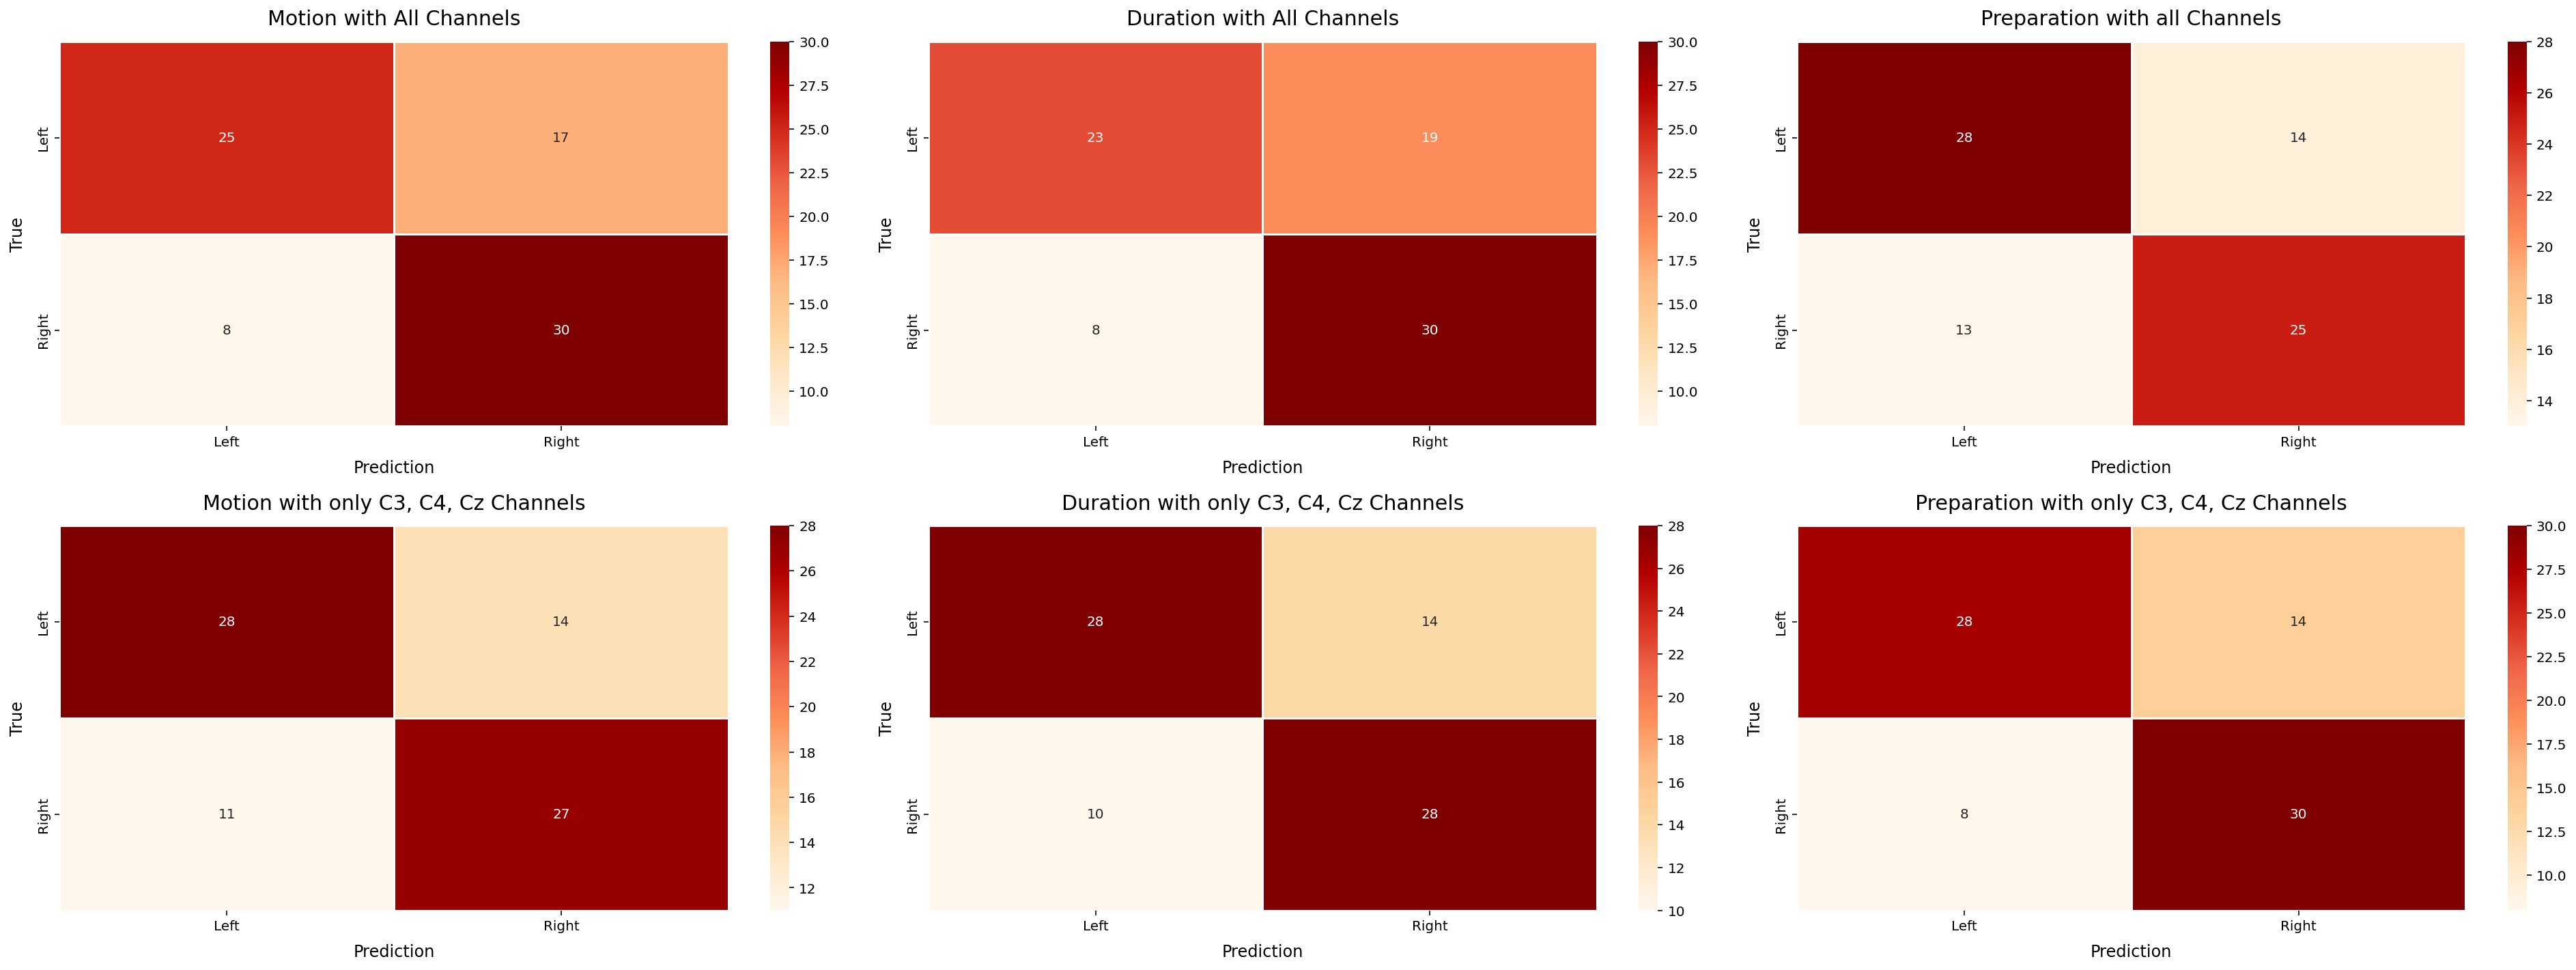

In [15]:
m_all_matrix = confusion_matrix(m_all_true, m_all_prediction)
d_all_matrix = confusion_matrix(d_all_true, d_all_prediction)
p_all_matrix = confusion_matrix(p_all_true, p_all_prediction)

m_remove_matrix = confusion_matrix(m_remove_true, m_remove_prediction)
d_remove_matrix = confusion_matrix(d_remove_true, d_remove_prediction)
p_remove_matrix = confusion_matrix(p_remove_true, p_remove_prediction)

targets = ["Left", "Right"]

plt.figure(figsize = (27, 10))

plt.subplot(231)
sns.heatmap(m_all_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = "d", xticklabels = targets, yticklabels = targets)
plt.title("Motion with All Channels", fontsize = 15, pad = 12)
plt.xlabel("Prediction", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.subplot(232)
sns.heatmap(d_all_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = "d", xticklabels = targets, yticklabels = targets)
plt.title("Duration with All Channels", fontsize = 15, pad = 12)
plt.xlabel("Prediction", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.subplot(233)
sns.heatmap(p_all_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = "d", xticklabels = targets, yticklabels = targets)
plt.title("Preparation with all Channels", fontsize = 15, pad = 12)
plt.xlabel("Prediction", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.subplot(234)
sns.heatmap(m_remove_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = "d", xticklabels = targets, yticklabels = targets)
plt.title("Motion with only C3, C4, Cz Channels", fontsize = 15, pad = 12)
plt.xlabel("Prediction", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.subplot(235)
sns.heatmap(d_remove_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = "d", xticklabels = targets, yticklabels = targets)
plt.title("Duration with only C3, C4, Cz Channels", fontsize = 15, pad = 12)
plt.xlabel("Prediction", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.subplot(236)
sns.heatmap(p_remove_matrix, annot = True, cmap = 'OrRd', linewidths = 1.5, fmt = "d", xticklabels = targets, yticklabels = targets)
plt.title("Preparation with only C3, C4, Cz Channels", fontsize = 15, pad = 12)
plt.xlabel("Prediction", fontsize = 12, labelpad = 8)
plt.ylabel("True", fontsize = 12, labelpad = 8)

plt.tight_layout()
plt.show()

# Results

In [16]:
# Motion with all channels
m_all_recall = round(recall_score(m_all_true, m_all_prediction) * 100, 2)
m_all_accuracy = round(accuracy_score(m_all_true, m_all_prediction) * 100, 2)
m_all_precision = round(precision_score(m_all_true, m_all_prediction) * 100, 2)

# Duration with all channels
d_all_recall = round(recall_score(d_all_true, d_all_prediction) * 100, 2)
d_all_accuracy = round(accuracy_score(d_all_true, d_all_prediction) * 100, 2)
d_all_precision = round(precision_score(d_all_true, d_all_prediction) * 100, 2)

# Preparation with all channels
p_all_recall = round(recall_score(p_all_true, p_all_prediction) * 100, 2)
p_all_accuracy = round(accuracy_score(p_all_true, p_all_prediction) * 100, 2)
p_all_precision = round(precision_score(p_all_true, p_all_prediction) * 100, 2)

# ----------------------------------------------------------------------------------------- #

# Motion with only C3, C4, Cz channels
m_remove_recall = round(recall_score(m_remove_true, m_remove_prediction) * 100, 2)
m_remove_accuracy = round(accuracy_score(m_remove_true, m_remove_prediction) * 100, 2)
m_remove_precision = round(precision_score(m_remove_true, m_remove_prediction) * 100, 2)

# Duration with only C3, C4, Cz channels
d_remove_recall = round(recall_score(d_remove_true, d_remove_prediction) * 100, 2)
d_remove_accuracy = round(accuracy_score(d_remove_true, d_remove_prediction) * 100, 2)
d_remove_precision = round(precision_score(d_remove_true, d_remove_prediction) * 100, 2)

# Preparation only C3, C4, Cz channels
p_remove_recall = round(recall_score(p_remove_true, p_remove_prediction) * 100, 2)
p_remove_accuracy = round(accuracy_score(p_remove_true, p_remove_prediction) * 100, 2)
p_remove_precision = round(precision_score(p_remove_true, p_remove_prediction) * 100, 2)

In [17]:
table = PrettyTable()
table.padding_width = 3

table.field_names = ["", "Recall Score", "Precision Score", "Accuracy Score"]
table.add_row(["Motion with All Channels", f"{m_all_recall:3.2f}%", f"{m_all_precision:3.2f}%", f"{m_all_accuracy:3.2f}%"])
table.add_row(["Duration with All Channels", f"{d_all_recall:3.2f}%", f"{d_all_precision:3.2f}%", f"{d_all_accuracy:3.2f}%"])
table.add_row(["Preparation with All Channels", f"{p_all_recall:3.2f}%", f"{p_all_precision:3.2f}%", f"{p_all_accuracy:3.2f}%"])
table.add_row(["Motion with only C3, C4, Cz Channels", f"{m_remove_recall:3.2f}%", f"{m_remove_precision:3.2f}%", f"{m_remove_accuracy:3.2f}%"])
table.add_row(["Duration with only C3, C4, Cz Channels", f"{d_remove_recall:3.2f}%", f"{d_remove_precision:3.2f}%", f"{d_remove_accuracy:3.2f}%"])
table.add_row(["Preparation with only C3, C4, Cz Channels", f"{p_remove_recall:3.2f}%", f"{p_remove_precision:3.2f}%", f"{p_remove_accuracy:3.2f}%"])

print(table)

+-----------------------------------------------+------------------+---------------------+--------------------+
|                                               |   Recall Score   |   Precision Score   |   Accuracy Score   |
+-----------------------------------------------+------------------+---------------------+--------------------+
|            Motion with All Channels           |      78.95%      |        63.83%       |       68.75%       |
|           Duration with All Channels          |      78.95%      |        61.22%       |       66.25%       |
|         Preparation with All Channels         |      65.79%      |        64.10%       |       66.25%       |
|      Motion with only C3, C4, Cz Channels     |      71.05%      |        65.85%       |       68.75%       |
|     Duration with only C3, C4, Cz Channels    |      73.68%      |        66.67%       |       70.00%       |
|   Preparation with only C3, C4, Cz Channels   |      78.95%      |        68.18%       |       72.50% 